# LSTM

Pytorch LSTM implementation for football match prediction.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.linear import Linear

In [3]:
import math

## Device

In [4]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print('Device:', device)

Device: cpu


## Dimensions

In [18]:
num_classes = 3   # number of classes
input_size = 5    # number of features in the input    
hidden_size = 4   # number of features in the hidden state
num_layers = 1    # number of recurrent lstm layers
seq_length = 5    # length of an input sequence
dropout = 0.0     # dropout rate

## LSTM model

In [19]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # number of classes
        self.input_size = input_size    # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers    # number of layers
        self.dropout = dropout          # dropout rate

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, dropout=dropout, batch_first=True) # LSTM
        self.fc = nn.Linear(hidden_size, num_classes) # fully connected output layer
    
        self.relu = nn.ReLU()

    def forward(self, x, hidden):
        out, _ = self.lstm(x, hidden) # LSTM forward pass
        out = out[:, -1, :]           # get output features (h_t) from the last layer of the LSTM, for last time step
        out = self.relu(out)          # ReLu
        out = self.fc(out)            # fully connected output layer
        return out

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device),
                  weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device))
        return hidden

    def init_linear(self, m):
        if isinstance(m, nn.Linear):
            # xavier normal initialization
            dim_in = m.weight.shape[1]
            dim_out = m.weight.shape[0]
            gain = 1. 
            u = gain * math.sqrt(2./(dim_in+dim_out))
            m.weight.data.normal_(0.0, math.pow(u,2)).to(device)

## Model

In [20]:
model = LSTM(num_classes, input_size, hidden_size, num_layers, dropout)
model.to(device)

LSTM(
  (lstm): LSTM(5, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=3, bias=True)
  (relu): ReLU()
)

## Training

Hyperparameters:

In [21]:
lr = 0.001            # learning rate
clip = 1.0            # gradient clipping range
weight_decay = 0.001  # l2 regularization

In [22]:
epochs = 10001

Loss:

In [23]:
criterion = nn.CrossEntropyLoss()

Optimizer:

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

## Training

Load training data:

In [12]:
training_data_batches = torch.load('../data/tensors/training_data_seq_batches.pt')

### Ploting

In [25]:
import matplotlib.pyplot as plt

In [26]:
def plot_training_validation_loss(training_losses, validation_losses):
    plt.plot(training_losses, color='red', marker='x', label='training loss') 
    plt.plot(validation_losses, color='orange', marker='x', label='validation loss')
    plt.ylabel('Cross Entropy Loss') 
    plt.xlabel('Batch')
    plt.title("Training/Validation Loss")
    plt.ylim([0.8, 1.2])
    plt.legend()
    plt.savefig('../results/lstm/lstm_' + str(dropout) + '_' + str(weight_decay) + '_' + str(num_layers) + '_' + str(hidden_size)+ '_' + str(lr) + '_' + str(clip) + '_train_val.png')
    plt.show() 

In [27]:
def plot_accuracy(accuracies):
    plt.plot(accuracies, color='blue', marker='x') 
    plt.ylabel('Accuracy') 
    plt.xlabel('Batch')
    plt.title("Training/Validation Loss")
    plt.ylim([0.4, 0.6])
    plt.savefig('../results/lstm/lstm_' + str(dropout) + '_' + str(weight_decay) + '_' + str(num_layers) + '_' + str(hidden_size)+ '_' + str(lr) + '_' + str(clip) + '_accuracy.png')
    plt.show() 

#### Blocked Cross-Validation

In [28]:
kfolds = 5
batch_size = len(training_data_batches[0][0])
validation_data_percentage = 0.2


Batch: 1
 Epoch: 0, training loss: 1.09
 Epoch: 500, training loss: 1.03
 Epoch: 1000, training loss: 0.99
 Epoch: 1500, training loss: 0.98
 Epoch: 2000, training loss: 0.98
 Epoch: 2500, training loss: 0.98
 Epoch: 3000, training loss: 0.98
 Epoch: 3500, training loss: 0.98
 Epoch: 4000, training loss: 0.98
 Epoch: 4500, training loss: 0.98
 Epoch: 5000, training loss: 0.98
 Epoch: 5500, training loss: 0.98
 Epoch: 6000, training loss: 0.98
 Epoch: 6500, training loss: 0.98
 Epoch: 7000, training loss: 0.98
 Epoch: 7500, training loss: 0.98
 Epoch: 8000, training loss: 0.98
 Epoch: 8500, training loss: 0.98
 Epoch: 9000, training loss: 0.98
 Epoch: 9500, training loss: 0.98
 Epoch: 10000, training loss: 0.98

Batch 1 Accuracy: 0.54, batch validation loss: 0.97

Batch: 2
 Epoch: 0, training loss: 0.98
 Epoch: 500, training loss: 0.98
 Epoch: 1000, training loss: 0.98
 Epoch: 1500, training loss: 0.98
 Epoch: 2000, training loss: 0.98
 Epoch: 2500, training loss: 0.98
 Epoch: 3000, tr

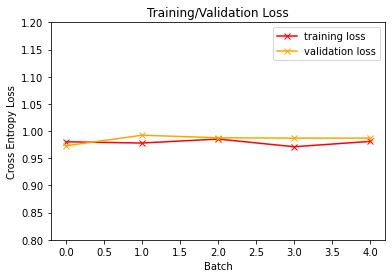

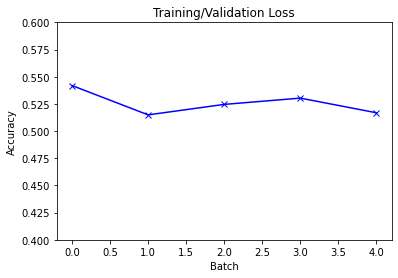

In [29]:
model.apply(model.init_linear)
training_loss, validation_loss, accuracy = [], [], [] 
for k in range(kfolds):
    # Block Cross Validation
    training_data, labels = training_data_batches[k]
    training_data = torch.stack(training_data)
    labels = torch.stack(labels)
    
    # Split Training/Validation Data
    training_batch_size = int(training_data.shape[0] * (1.0 - validation_data_percentage))

    training_data_fold = training_data[:training_batch_size, :, :].to(device)
    validation_data_fold = training_data[training_batch_size:, :, :].to(device)

    training_labels_fold = labels[:training_batch_size, :].to(device)
    validation_labels_fold = labels[training_batch_size:, :].to(device)

    # training on training dataset
    print("\nBatch: %d" % (k+1))
    model.train()
    for epoch in range(epochs):
        model.zero_grad()
        h = model.init_hidden(training_batch_size)
        output = model(training_data_fold, h)
        loss = criterion(output, training_labels_fold)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip) # gradient clipping
        optimizer.step()
  
        if epoch % 500 == 0:
            print(" Epoch: %d, training loss: %1.2f" % (epoch, loss.item()))

    training_loss.append(loss.item())

    # validation on training dataset
    validation_batch_size = validation_data_fold.shape[0]
    model.eval()
    validation_loss_batch, accuracy_batch = 0.0, 0.0
    with torch.no_grad():
        h = model.init_hidden(validation_batch_size)
        prediction = model(validation_data_fold, h)
        validation_loss_batch = criterion(prediction, validation_labels_fold).item()
        accuracy_batch = ((torch.argmax(prediction, dim=1) == torch.argmax(validation_labels_fold, dim=1)).type(torch.float).sum()) / validation_batch_size
    print("\nBatch %d Accuracy: %1.2f, batch validation loss: %1.2f" % (k+1, accuracy_batch, validation_loss_batch))

    validation_loss.append(validation_loss_batch)
    accuracy.append(accuracy_batch.cpu())
training_loss_avg = sum(training_loss) / kfolds
validation_loss_avg = sum(validation_loss) / kfolds
accuracy_avg = sum(accuracy) / kfolds
print("\nAccuracy: %1.2f, trainig loss: %1.2f, validation loss: %1.2f" % (accuracy_avg, training_loss_avg, validation_loss_avg))
plot_training_validation_loss(training_loss, validation_loss)
plot_accuracy(accuracy)